In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import matplotlib.pyplot as plt

2024-10-28 11:01:43.496793: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 11:01:43.730924: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 11:01:43.951596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 11:01:44.181623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 11:01:44.237855: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 11:01:44.584571: I tensorflow/core/platform/cpu_feature_gu

In [3]:
IMAGE_SIZE = 64
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


I0000 00:00:1730109710.886448    7705 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-28 11:01:50.887253: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
len(dataset)

2580

The length of the dataset is 645 because every element in it is a batch of 32
images. 

$645 \cdot 32 = 20640$ images

But there are 20638 images in the dataset, meaning that the last batch is 
incomplete.

2024-10-28 11:01:51.166356: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


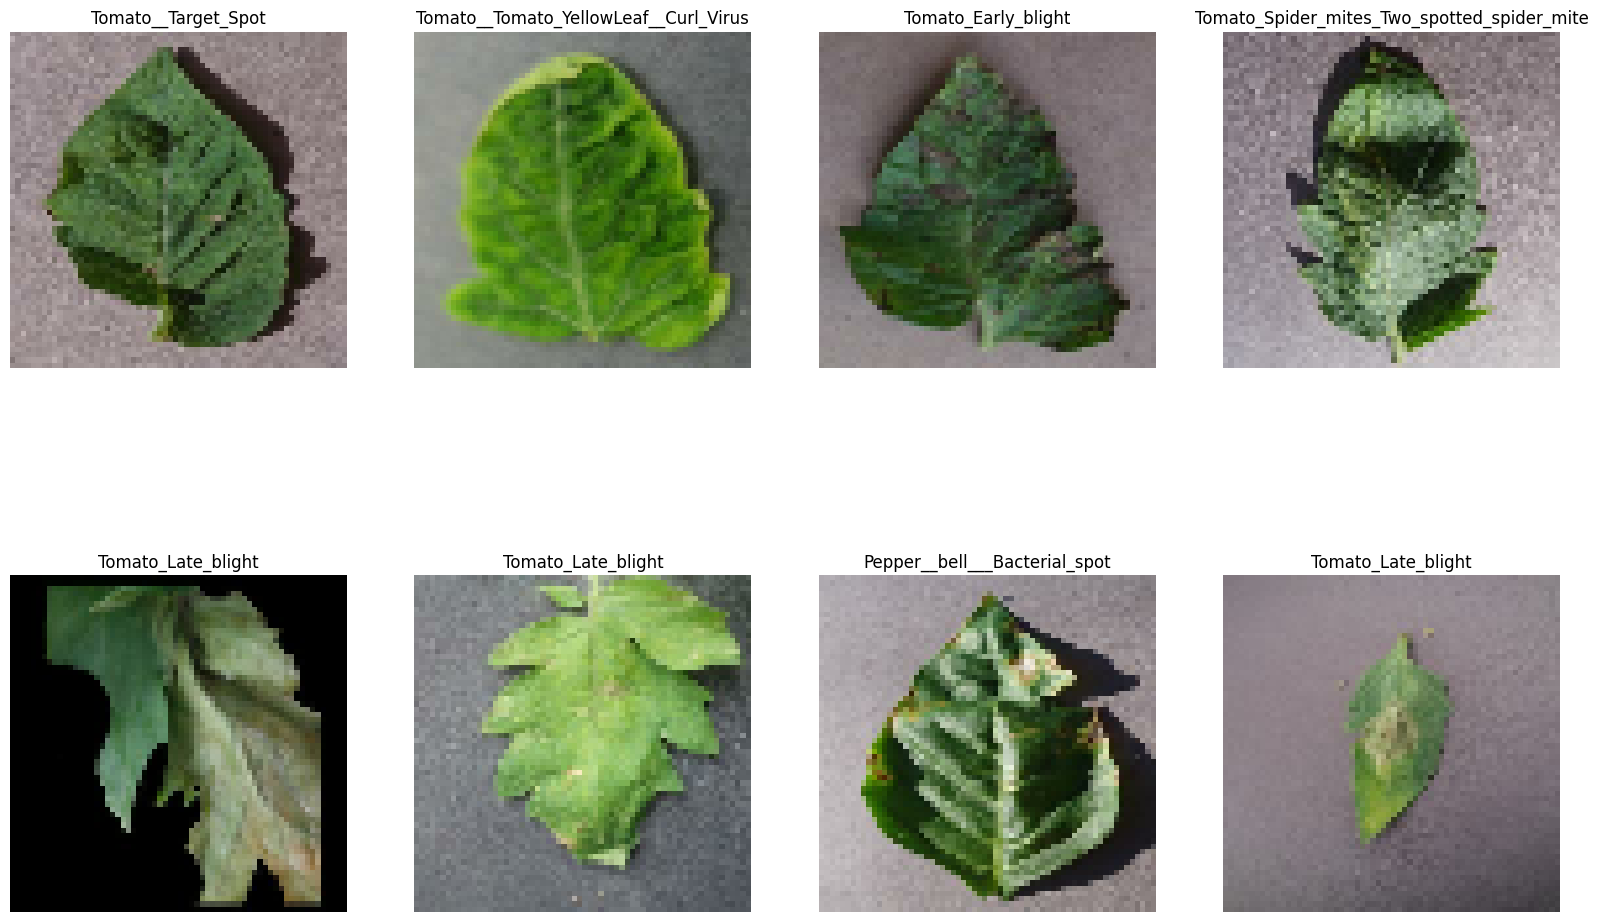

In [7]:
plt.figure(figsize=(20, 20))
for image_batch, label_batch in dataset.take(1):
    # print(image_batch.shape, label_batch.shape)
    for i in range (8):
        ax = plt.subplot(3, 4, i + 1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
train_size = 0.70
len(dataset)*train_size

1805.9999999999998

In [9]:
train_ds = dataset.take(1805)

In [10]:
len(train_ds)

1805

In [11]:
test_ds = dataset.skip(1805)
len(test_ds)

775

In [12]:
val_size = 0.15
len(dataset)*val_size

387.0

In [13]:
val_ds = test_ds.take(387)
len(val_ds)

387

In [14]:
test_ds = test_ds.skip(387)
len(test_ds)

388

In [15]:
def get_tf_dataset_splits(ds, train_split = 0.7, val_split = 0.15, 
                          shuffle = True, 
                          shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_tf_dataset_splits(dataset)

In [17]:
len(train_ds)

1805

In [18]:
len(val_ds)

387

In [19]:
len(test_ds)

388

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
len(class_names)

15

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Conv2D(32, (3,3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])


/home/osita/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (8, 64, 64, 3)         │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (8, 62, 62, 32)        │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (8, 31, 31, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (8, 29, 29, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (8, 14, 14, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (8, 12, 12, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (8, 6, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (8, 2304)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (8, 64)                │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (8, 15)                │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,815 (800.06 KB)

 Trainable params: 204,815 (800.06 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [26]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('training.log', separator=',', append=False)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[csv_logger]
)

Epoch 1/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 59s 30ms/step - accuracy: 0.2697 - loss: 2.2015 - val_accuracy: 0.5081 - val_loss: 1.4992
Epoch 2/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 50s 28ms/step - accuracy: 0.5840 - loss: 1.2581 - val_accuracy: 0.6466 - val_loss: 1.0402
Epoch 3/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 51s 28ms/step - accuracy: 0.6988 - loss: 0.8775 - val_accuracy: 0.6631 - val_loss: 0.9864
Epoch 4/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 51s 28ms/step - accuracy: 0.7465 - loss: 0.7366 - val_accuracy: 0.7639 - val_loss: 0.6500
Epoch 5/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 50s 28ms/step - accuracy: 0.7715 - loss: 0.6688 - val_accuracy: 0.7878 - val_loss: 0.6074
Epoch 6/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 51s 28ms/step - accuracy: 0.7961 - loss: 0.5843 - val_accuracy: 0.7326 - val_loss: 0.7929
Epoch 7/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 50s 28ms/step - accuracy: 0.8113 - loss: 0.5519 - val_accuracy: 0.7787 - val_loss: 0.6431
Epoch 8/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 50s 28ms/step - accuracy: 0.8344 -

- Train split = 70/15/15
- Shap XAI
- Graph the training *
- Save the model

Tried training for 10 epochs first.
Tried training for 20 epochs second.
Now, I'll try training for 15 epochs.

In [27]:
model.evaluate(test_ds)

388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9345 - loss: 0.2089


[0.22504760324954987, 0.9274661540985107]

In [32]:
model_version = 2
model.save(f"../models/{model_version}.keras")

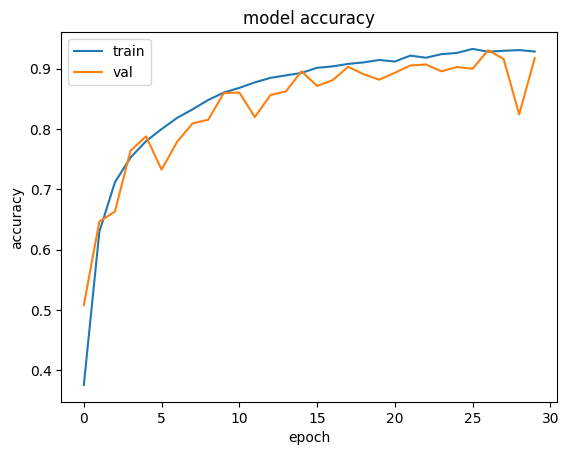

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

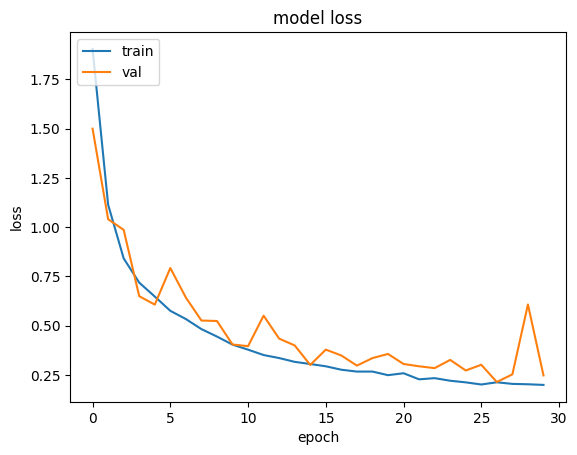

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

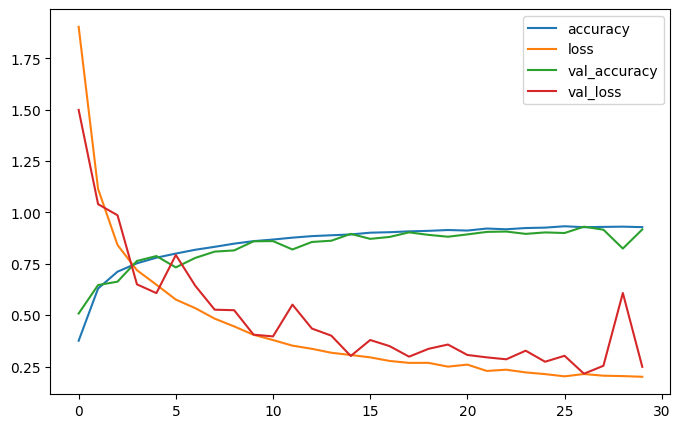

In [31]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()